# **Finetuning to Follow Instructions**

In [1]:
from importlib.metadata import version

pkgs = [
    "numpy",       
    "matplotlib", 
    "tiktoken",    
    "torch",      
    "tqdm",        
    "tensorflow",
]

for p in pkgs:
    print(f"{p} version:{version(p)}") 

numpy version:2.2.5
matplotlib version:3.10.1
tiktoken version:0.9.0
torch version:2.7.0
tqdm version:4.67.1
tensorflow version:2.19.0


## **1. Instruction Finetuning**

Add Prose...

## **2. Dataset Preparation for Supervised Finetuning**

In [2]:
import json, os, requests

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        text_data = response.text
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
            
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)
        
    return data

In [3]:
file_path = "data/instruct/instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json" 
)

data = download_and_load_file(file_path, url)
print("Number of entries", len(data))

Number of entries 1100


In [4]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [5]:
print("Another example entry:\n", data[444])

Another example entry:
 {'instruction': "Provide the past participle form of 'choose.'", 'input': '', 'output': "The past participle form of 'choose' is 'chosen.'"}


- Items in the downloaded `data` list are stored as dictionaries.
- Entries may contain empty `input` fields. 
- There are a number of ways to format the entries as inputs to the LLM; Two example formats that were used for training the Alpaca (https://crfm.stanford.edu/2023/03/13/alpaca.html) and Phi-3 (https://arxiv.org/abs/2404.14219) LLMs are illustrated below.
    - Alpaca-style prompt formatting was the original prompt template for instruction fine-tuning.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/04.webp?2" width=640px>

In [6]:
# Proceeding with the Alpaca style prompt formatting.
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a reponse that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    
    return instruction_text + input_text

In [7]:
# Demonstration of a formatted response with input fields
model_input = format_input(data[50])
desired_response = f"\n\n#### Response:\n{data[50]['output']}"

print(model_input, desired_response)

Below is an instruction that describes a task. Write a reponse that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion 

#### Response:
The correct spelling is 'Occasion.'


In [8]:
# Example where the input field is empty
model_input = format_input(data[444])
desired_response = f"\n\n#### Response:\n{data[444]['output']}"

print(model_input, desired_response)

Below is an instruction that describes a task. Write a reponse that appropriately completes the request.

### Instruction:
Provide the past participle form of 'choose.' 

#### Response:
The past participle form of 'choose' is 'chosen.'


- Diving the dataset into `training`, `validation` and `test` sets before passing them to the dataloaders.

In [9]:
train_set = int(len(data) * 0.85)
test_set = int(len(data) * 0.1)
val_set = len(data) - train_set - test_set

train_data = data[:train_set]
test_data = data[train_set : train_set + test_set]
val_data = data[train_set + test_set:]

In [10]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## **3. Organizing Data into Training Batches**

Dataset batching is summarized in the figure below...

- We tackle this dataset batching in several steps, as summarized in the figure below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/06.webp?1" width=640px>

- We will implement an `InstructionDataset` class which pretokenizes all inputs in the dataset.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/07.webp?1" width=640px>

In [11]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        
        # Pre-tokenizing the text
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )
    
    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)

- As before, all input batches will be padded to a similar length.
- We will be using the `<|endoftext|>` token as a padding token.

In [12]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [13]:
# Developing a custom collate function that can be passed to the dataloader.
# Its purpose is to pad the training examples in each batch to have the same length
# Note that different batches may vary in length.
def collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cuda"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1 to add an extra
    # padding token.
    batch_max_length = max(len(item)+1 for item in batch)
    
    # Pad and prepare inputs
    inputs_lst = []
    
    for item in batch:
        new_item = item.copy()
        # Add the padding token
        new_item += [pad_token_id] 
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item))
        )
        # padded[:-1] allows us to remove the extra padded token
        # which was added with +1 in batch_max_length. We will
        # circle back to the extra padding token in later sections.
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)
    
    # Convert list of inputs to tensor and transfer to target device.
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [14]:
inp_1 = [0, 1, 2, 3, 4, 5]
inp_2 = [6, 7]
inp_3 = [8, 9, 10]

batch = (
    inp_1,
    inp_2,
    inp_3
)

batch

([0, 1, 2, 3, 4, 5], [6, 7], [8, 9, 10])

In [15]:
print(collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4,     5],
        [    6,     7, 50256, 50256, 50256, 50256],
        [    8,     9,    10, 50256, 50256, 50256]], device='cuda:0')


- The collate function above only handles inputs to an LLM. To allow training for instruction following, we will need the target values as well.
- Similar to pretraining an LLM, targets will simply be inputs shifted by 1 position to the right to allow next-token predictions.

In [16]:
# Modifying the collate function

def collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cuda"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)
    
    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []
    
    for item in batch:
        new_item = item.copy()
        # Add padding token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1]) # Truncate last token for inputs
        targets = torch.tensor(padded[1:]) # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)
        
    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [17]:
inputs, targets = collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4,     5],
        [    6,     7, 50256, 50256, 50256, 50256],
        [    8,     9,    10, 50256, 50256, 50256]], device='cuda:0')
tensor([[    1,     2,     3,     4,     5, 50256],
        [    7, 50256, 50256, 50256, 50256, 50256],
        [    9,    10, 50256, 50256, 50256, 50256]], device='cuda:0')


- Introducing an `ignore_index` value to replace all padding token IDs with a new value. This new value will be ignored during loss calculations.
- In this case, we will be replacing `50256` with `-100`.
- We will also introduce `allowed_max_length` in case we want to limit the length of the samples. 

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/11.webp?1" width=640px>

In [18]:
def collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cuda"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []
    
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        
        # Replace all except the first padding tokens in targets using ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        # Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
            
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    
    return inputs_tensor, targets_tensor

In [19]:
inputs, targets = collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4,     5],
        [    6,     7, 50256, 50256, 50256, 50256],
        [    8,     9,    10, 50256, 50256, 50256]], device='cuda:0')
tensor([[    1,     2,     3,     4,     5, 50256],
        [    7, 50256,  -100,  -100,  -100,  -100],
        [    9,    10, 50256,  -100,  -100,  -100]], device='cuda:0')


### 3.1 The Role of `-100` in Ignoring Padding Tokens

- Assuming a trivial classification task with 2 class labels, 0 and 1.
- Calculating the loss based on the logit values below.

In [20]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5]]
)
targets_1 = torch.tensor([0, 1])

loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [21]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [22]:
# Replacing the class label of one of the examples with -100
targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3: ", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3:  tensor(True)


- This shows that cross-entropy loss function ignored the training example with `-100` label.
- PyTorch, by default, has the `cross_entropy(..., ignore_index=-100)` setting to ignore examples corresponding to the -100 label.
- This allows us to ignore the end-of-text / padding tokens in the training batches.
- Do note that we **don't** want to ignore the first instance of the end-of-text padding token (50256) because it serves as a signal to the LLM that the reponse is complete.
- Target token IDs, which correspond to instructions, are commonly masked out as well.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/13.webp" width=640px>

## **4. Creating DataLoaders for the Instruction Dataset**

- `collate_fn` allows us to move the data to the `gpu` directly, thereby bypassing the main the training loop for added efficiency.
- The `partial` function will be used to create a new function with a pre-filled `device` argument. 

In [23]:
device = torch.device("cuda")
print(device)

cuda


In [24]:
from functools import partial

customized_collate_fn = partial(
    collate_fn,
    device=device,
    allowed_max_length=1024
)

- `collate_fn` will be used in the batching process once the dataloaders are instantiated.

In [25]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [26]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [27]:
# Viewing dimensions of the resulting input and target batches
print("Train Loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train Loader:
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 78]) torch.Size([8, 78])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 69]) torch.

- All batches have a batch size of 8, but varying lengths. We will also double check that the inputs contain `<|endoftext|>` padding tokens corresponding to token ID `50256`.

In [28]:
print(inputs[0], "\n", len(inputs))

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  1128,  2591,   326, 20431, 32543,   262,  2581,    13,   198,
          198, 21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,
          257,   985,   576,    13,   198,   198, 21017, 23412,    25,   198,
          464,  5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,
           25,   198,   464,  5156,   318,   355, 13779,   355,   257,  4936,
           13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0') 
 8


In [29]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         1128,  2591,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')


## **5. Loading a Pre-trained LLM**

In [30]:
from supplementary.utils.components import GPTModel
from supplementary.utils.gpt_generate import load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

2025-11-05 13:19:56.412978: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-05 13:19:56.420206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762330796.428558   50402 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762330796.431020   50402 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762330796.437629   50402 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [31]:
file_name = "gpt2/gpt2-medium-355M.pth"

model = GPTModel(BASE_CONFIG)
model.load_state_dict(torch.load(file_name, weights_only=True))
model.eval();

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device);

- Testing the model on a validation task before finetuning.

In [32]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a reponse that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [33]:
from supplementary.utils.gpt_generate import (
    generate, text_to_token_ids, token_ids_to_text
)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)

generated_text = token_ids_to_text(token_ids, tokenizer)

- Compared to previous NBs, where the `generate` function returned both input and output text, we will now need to isolate the response by subtracting the length of the instruction from the start of the `generated_text`.

In [34]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Reponse:", "")
    .strip()
)

print(response_text)

### Example:

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Example:


- The model isn't capable of following instructions at present. Creating a `Response` section only ends up repeating the original input sentence and the instruction.

## **6. Finetuning the LLM on Instruction Data**

- Reusing the loss calculation and training functions in the `components` module.

In [35]:
from supplementary.utils.components import (
    calc_loss_loader,
    train_model_simple
)

In [36]:
# Calculating the initial training and validation set loss prior to finetuning the model.abs
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.896774673461914
Validation loss: 3.8306540966033937


In [37]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    device,
    num_epochs=num_epochs, 
    eval_freq=5, 
    eval_iter=5,
    start_context=format_input(val_data[0]), 
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_mins = (end_time - start_time) / 60
print(f"Training completed in {execution_time_mins:.2f} minutes.")

Epoch 1 (Step 000000): Train loss 2.730, Val loss 2.706
Epoch 1 (Step 000005): Train loss 1.163, Val loss 1.086
Epoch 1 (Step 000010): Train loss 0.849, Val loss 0.920
Epoch 1 (Step 000015): Train loss 0.846, Val loss 0.894
Epoch 1 (Step 000020): Train loss 0.765, Val loss 0.865
Epoch 1 (Step 000025): Train loss 0.741, Val loss 0.838
Epoch 1 (Step 000030): Train loss 0.786, Val loss 0.820
Epoch 1 (Step 000035): Train loss 0.708, Val loss 0.791
Epoch 1 (Step 000040): Train loss 0.660, Val loss 0.786
Epoch 1 (Step 000045): Train loss 0.626, Val loss 0.775
Epoch 1 (Step 000050): Train loss 0.660, Val loss 0.769
Epoch 1 (Step 000055): Train loss 0.744, Val loss 0.750
Epoch 1 (Step 000060): Train loss 0.710, Val loss 0.732
Epoch 1 (Step 000065): Train loss 0.643, Val loss 0.721
Epoch 1 (Step 000070): Train loss 0.527, Val loss 0.715
Epoch 1 (Step 000075): Train loss 0.560, Val loss 0.715
Epoch 1 (Step 000080): Train loss 0.594, Val loss 0.707
Epoch 1 (Step 000085): Train loss 0.500, Val los

- Model training progressed as expected with the sample response being printed after every epoch.
- The instruction to convert `The chef cooks the meal everyday` into passive voice `The meal is cooked every day by the chef` indicates that the model will now begin to follow instructions more closely.

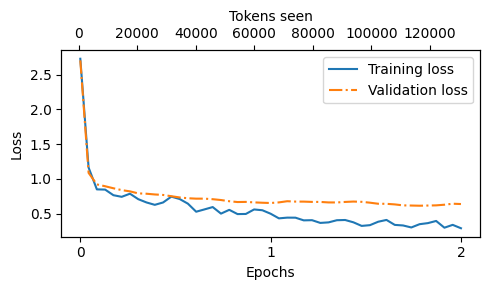

In [38]:
from supplementary.utils.components import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- Overfitting begins to set in around 1 training epoch.